In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Linear SVM Classification

Let's take a look at some images first: 

In [2]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=1e9)
svm_clf.fit(X, y)

SVC(C=1000000000.0, kernel='linear')

Saving figure large_margin_classification_plot


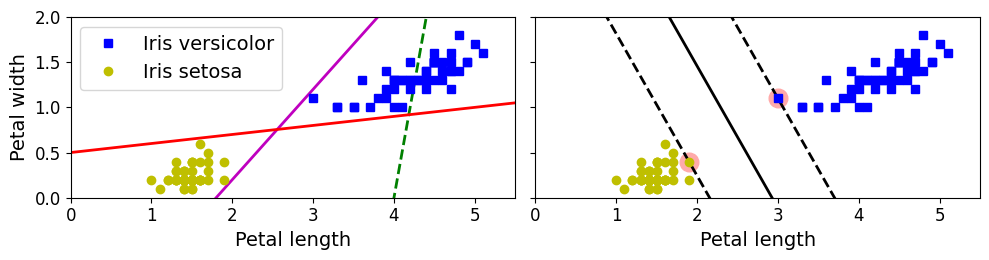

In [3]:
# Bad models
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

save_fig("large_margin_classification_plot")
plt.show()

**Linearly Seperable**: the two classes can be seperated easily with a straight line.
* Left shows decisionn boundaries of three possible linear classifiers
* plot on right (solid line) shows decision boundary of SVM classifier: not only seperates the classes but stays as far as possible from the nearest training instance
* **Large Margin Classification**: fitting the widest possible street (represented by the parallel dashed lines). Fully determiend by the instances on the edge of the street, called **support vectors** (circled).
* Feature scaling is good practice when using svm classifiers. 

## Soft Margin Classification

**Hard Margin Classification**: if we strictly impose that all instances must be off the street annd on the right side. 
* Issues:
    1. Only works if data is linnearly seperable
    2. Sensitive to outliers
* **Soft Margin Classification**-objective: to find a good balannce between keeping the street as wide as possible and avoiding **margin violations**.
* If your SVM model is overfitting, you can try regularizing it by reducing C.


In [4]:
#loads iris dataset, scales features, then trains a liinear SVM model 
#to detect Iris virginica flowers
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] #petal length, petal wiidth
y = (iris["target"] == 2).astype(np.float64) #Iris virginica

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
])
svm_clf.fit(X, y)

/Users/peteranderson/Desktop/Machine_Learning/Chapter_5/ch5env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

In [5]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

Unlike Logistic Regression Classifiers, SVM classiers do not output probabilities for each class
* Alternative: use SVC class with a linear kernel: SVC(kernel="linear", C=1).
* Alternative: SGDClassifier(loss="hinge", alpha=1/(m*C)). Thisi applies regular stochastic gradient descent to train a linear SVM classifier, more useful for online and large dataset classification that do not fit in memory
* For LinearSVC
    1. It includes a bias term, so use standardscaler to center it
    2. Set loss hyperparameter to hinge
    3. Set dual hyperparameter to false, unless theres more features than training instances 


# NonLinear SVM Classification

* Possible solution to nonlinear datasets: add more features, such as polynomial features. 

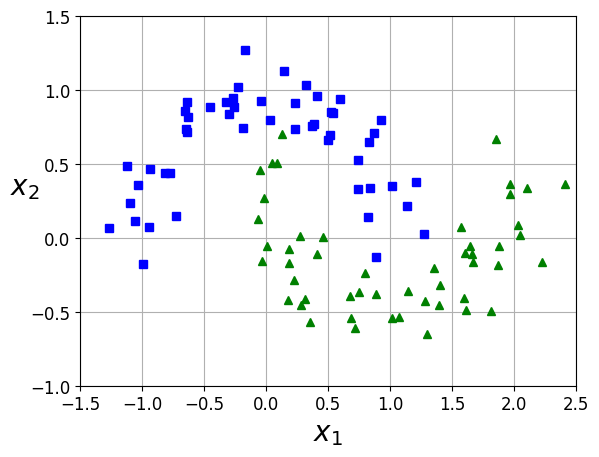

In [6]:
#Example: on moons dataseta: toy dataset for binary classification 
#in which data points are shaped as two interleaving half circles

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [7]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15)
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge"))
])

polynomial_svm_clf.fit(X, y)

/Users/peteranderson/Desktop/Machine_Learning/Chapter_5/ch5env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/peteranderson/Desktop/Machine_Learning/Chapter_5/ch5env/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

Saving figure moons_polynomial_svc_plot


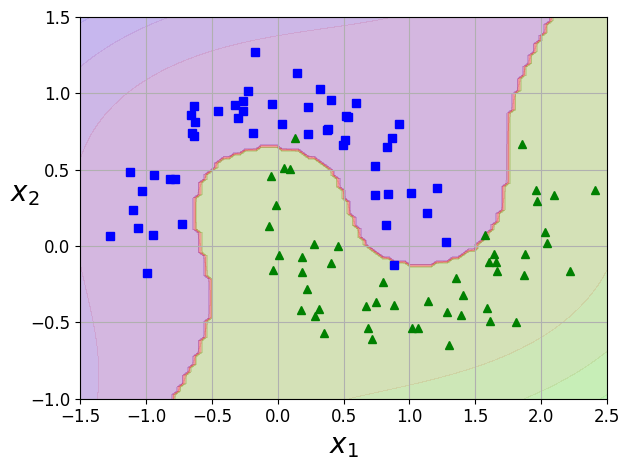

In [8]:
#linear svm classifier using polynomial features
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

## Polynomial Kernel

* Low polynomial degree: model cannot deal with very complex datasets
* High polynomial degree: model creates a huge number of features, making the model too slow
* **Kernel Trick**: makes iit posisble to get the same result as if you added many polynomial features, without adding them, so there isn't a huge explosion of features. 

In [9]:
#testing kernel trick on moons dataset

from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])

poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

Saving figure moons_kernelized_polynomial_svc_plot


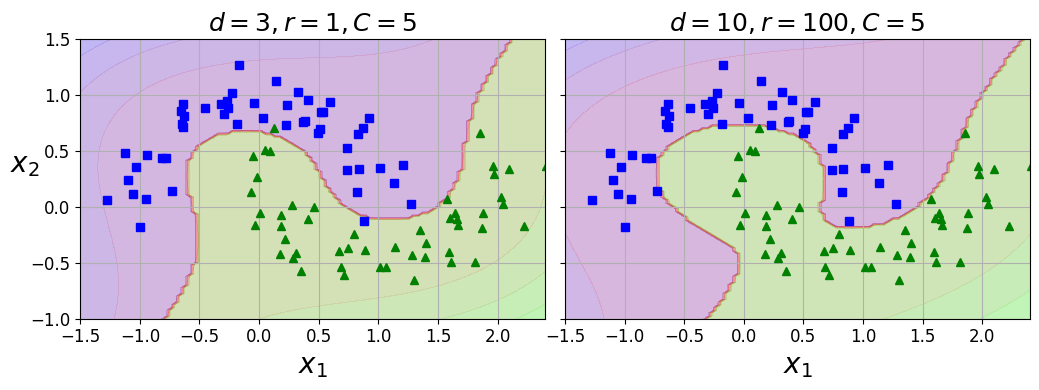

In [10]:
#svm classifiers with a polynomial kernel
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

Doing a course grid search around ttthe best values found is a good and faster approach to finding the best hyperparameter values. 

## Similarity Features--Explained in notebook

* Ex: Take the 1D dataset, add two landmarks at x_1 = -2, and x_1 = 1. next, define the similarirty function to be the guassian Radial Basis Function (RBF), in notebook with gamma = 0.3.
* Next, look at x_1 = -1. Itt is located 1 away from the first landmark and 2 from the second. Therefore itst new features are x_2 = exp(-0.3 x 1^2) which is approx 0.74, and x_3 = exp(-0.3 x 2^2) which is approx 0.3. The right plot shows the transofrmed dataset(dropping the original features) and itst not linearly seperable. 


Saving figure kernel_method_plot


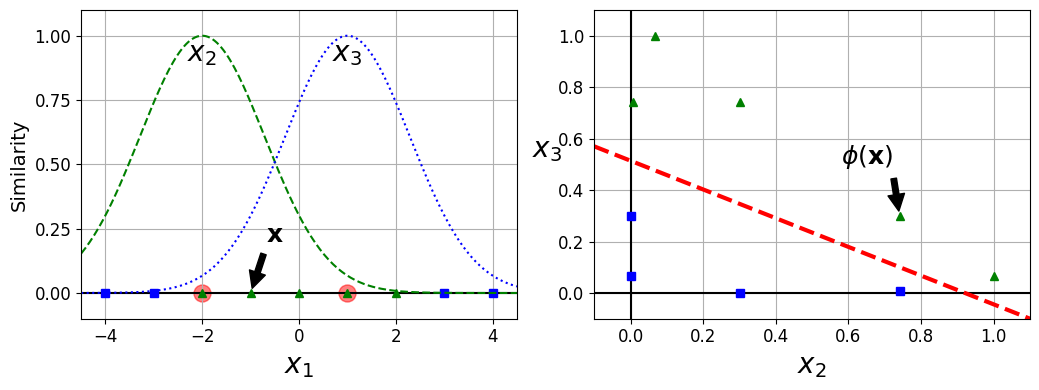

In [11]:
#similarity features using the guassian rbf
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

* Selecting landmarks:
    * Create a landmark at the location of each and every instannce of the dataset. It creates many dimensions thus increasing the chances the trasformed dataset will be linearly seperable.
    * Large number of features is the downside. 

## Guassian RBF Kernel
* uses kernel trick to do the work of similarity features using the guassian RBF without actually doing it so it saves computational cost. 

In [12]:
#trying a SVC class with a Gussian RBF kernel
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma = 5, C = 0.001))
])

rbf_kernel_svm_clf.fit(X, y)


ValueError: Found input variables with inconsistent numbers of samples: [100, 9]

In [13]:
#SVM classifiers using a RBF kernel with varying hyperparameters
#using moons dataset

#OUTPUT NOT CORRECT
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [100, 9]

* The above output isn't correct, but basically, increasing gamma makes the bell-shaped curve narrower, so each instance's influence is smaller: decision boundary more irregular, wiggling around individual instances.
* A small gamma makes the bell-shaped curve wider, instances have a large rannge of iinfluence, and the dicision boundary ends up smoother.
* Gamma is a regularization parameter: if model is overfitting, you should reduce it; it its underfitting, you should increase it

* Which kernels to choose?
    1. Always try linear kernel first.
    2. If training set is too large, you should try the Guassian RBF kernel.
    3. There may always be specialized kernels for your data structure. 

# SVM Regression

* **Objective**: try to fit as many instances as possible on the street while limiting marginn violations (off the street).
    * Note: adding more training instances within the margin does not affect the models predictions; thus the model is said to be epsilon insensitive.
    * For nonlinear regression tasks, use a kernalized SVM model
    * Note: epsilon is the tolerance, which controls your precision (makes the road narrower)

In [14]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [15]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon = 1.5)
svm_reg.fit(X, y)

/Users/peteranderson/Desktop/Machine_Learning/Chapter_5/ch5env/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVR(epsilon=1.5)

In [16]:
#for nonnlinear tasks 
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [17]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')

In [18]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, degree=2, kernel='poly')

Saving figure svm_with_polynomial_kernel_plot


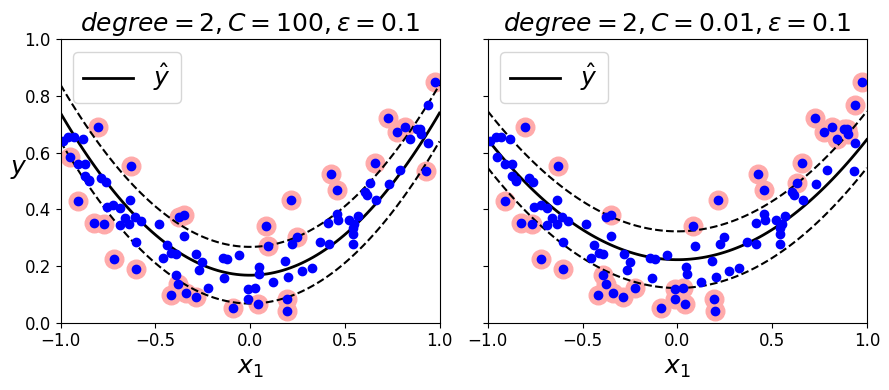

In [19]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

In [21]:
#note the regularization in the left plot
#example usinig Scikit-learns SVR class (which supports the kernel trick) to produce the model on the left
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 + X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [23]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)
#if traininng set is very large, use LinnearSVR instead
#it scales linearly 

SVR(C=100, degree=2, kernel='poly')